<div style="text-align: center;"> <h3>Statistical Theory</h3>
<h5>Formative Assessment 9</h5>
<h5><u>By Romand Lansangan</u></h5>
    </div>
    
---

## Introduction
The Political Interest dataset is a set of collected data to test the idea of higher educational attainment increases the likelihood of a person's political interest.

In the dataset, there are three columns: Gender (1: Male; 2: Female), Educational level (1: School, 2: College, 3: University) and their political interest measured at a continuous level.

## Methodology
We ought to use Two-Way Anova to test for interactions effect in our dataset. With that being said, the hypothesis are as follows:

**Null Hypothesis ($H_0$)**: There is no significant interaction effect on political interest between gender and education level. 

**Alternative Hypothesis ($H_1$)**: There is a significant interaction effect on political interest between gender and education level.

We ought to test the null hypothesis at a 0.05 significance level. In other words, we ought to reject the null hypothesis if and only if p-value < 0.05. But it is also worth noting the choosing a 0.05 level of significance poses a risk of commiting a type I error (false positive; rejecting null hypothesis when it should be accepted) 5% of the time.

---

In [24]:
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [3]:
df = pd.read_csv('Political Interest.csv')
df.head()

,gender,education_level,political_interest
0,1,1,38.0
1,1,1,39.0
2,1,1,35.0
3,1,1,38.0
4,1,1,41.0


## Checking for assumptions

### Assumption 1: You have one dependent variable that is measured at the continuous level (i.e., the interval or ratio level).
In our case, the dependent variable shall be the 'political_interest' column, which is measured at the continuous level.

### Assumption 2: You have two independent variables where each independent variable consists of two or more categorical, independent groups.
We have two independent and categorical variables: 'gender' (1: Male; 2: Female) and 'educational_level' (1: School, 2: College, 3: University).

Note that since we have two factors, with gender have 2 categories and education level having 3 categories, we'll have a total of $2 \times 3 = 6$ cells.

In [4]:
gender_mapping = {1: 'Male', 2: 'Female'}
education_mapping = {1: 'School', 2: 'College', 3: 'University'}

df['gender'] = df['gender'].map(gender_mapping)
df['education_level'] = df['education_level'].map(education_mapping)
df.head()

,gender,education_level,political_interest
0,Male,School,38.0
1,Male,School,39.0
2,Male,School,35.0
3,Male,School,38.0
4,Male,School,41.0


### Assumption 3: You should have independence of observations
Since gender and education level are two distinct groups/categories, there's no issue here.

### Assumption 4: There should be no significant outliers in any cell of the design.

We have used the IQR method to flag outliers. The IQR is computed as follows:

$$
IQR = Q_3 - Q_1
$$

Then the acceptable range for observed data shall be:
$$
(Q_1 - 1.5 \times IQR \  \ , \ \ Q_3 + 1.5 \times IQR) 
$$

Any values outside of this interval shall be flagged as outliers.

In [5]:
grouped = df.groupby(['gender', 'education_level'])

outlier_info = []

for (gender, edu_level), group in grouped:
    Q1 = group['political_interest'].quantile(0.25)
    Q3 = group['political_interest'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = group[(group['political_interest'] < lower_bound) | (group['political_interest'] > upper_bound)]
    
    outlier_info.append({
        'gender': gender,
        'education_level': edu_level,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers': outliers['political_interest'].tolist()
    })

outlier_df = pd.DataFrame(outlier_info)
outlier_df

,gender,education_level,Q1,Q3,IQR,Lower Bound,Upper Bound,Outliers
0,Female,College,43.00,46.75,3.75,37.375,52.375,[]
1,Female,School,38.00,41.75,3.75,32.375,47.375,[]
2,Female,University,55.50,62.50,7.00,45.000,73.000,[]
3,Male,College,41.50,44.50,3.00,37.000,49.000,[]
4,Male,School,36.00,39.00,3.00,31.500,43.500,[]
5,Male,University,62.25,65.50,3.25,57.375,70.375,[]


If we take a look on the 'Outliers' column above, it will appear that there's no flagged outlier behind every cell, as assessed by the IQR method. 

A quick look the these raincloud plots will reinforce this idea..

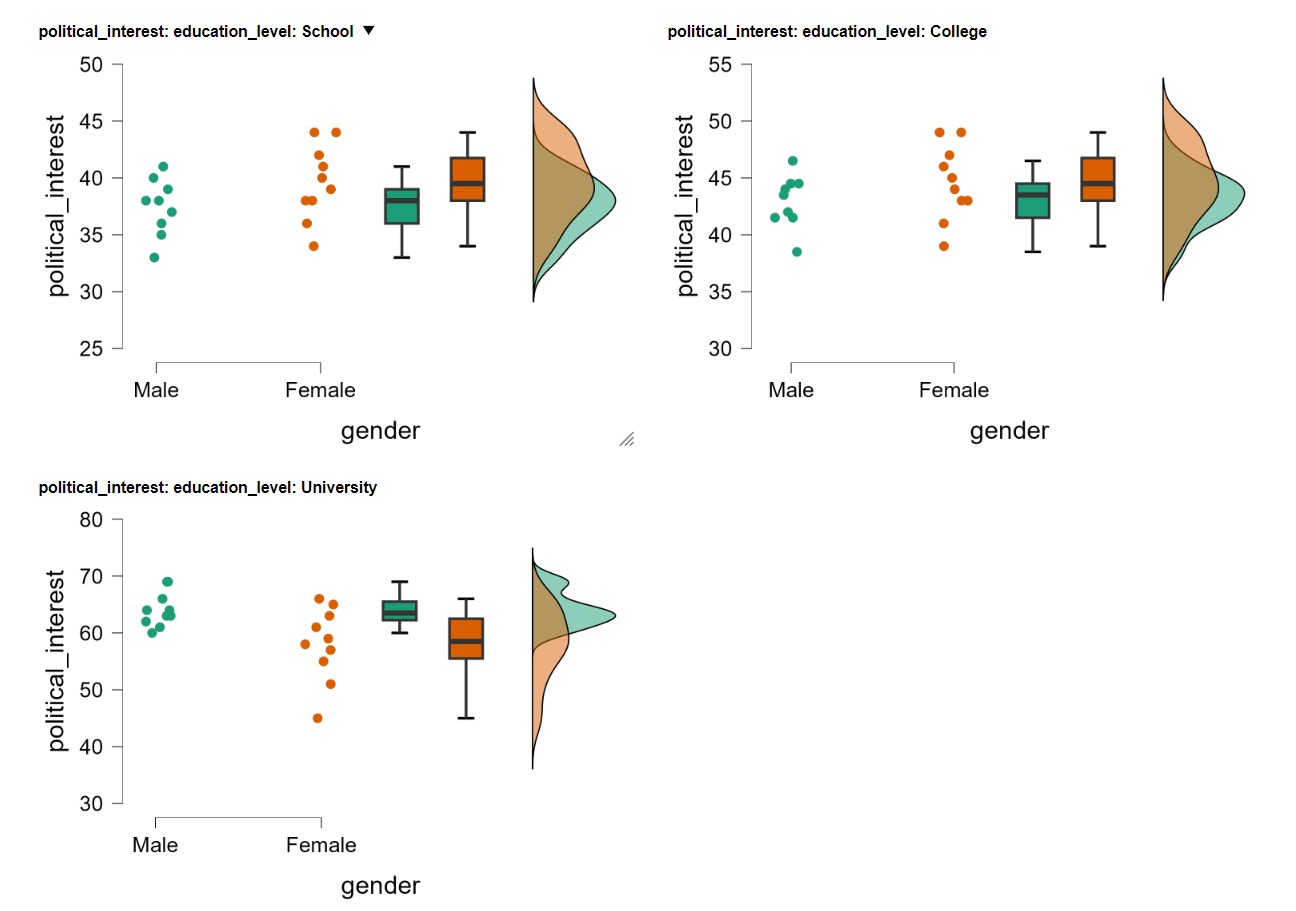

### Assumption 5: The distribution of the dependent variable (residuals) should be approximately normally distributed in every cell of the design.
Let us now test for normality using Shapiro-Wilk test.

In [6]:
normality_results = []

for (gender, edu_level), group in grouped:
    stat, p_value = shapiro(group['political_interest'])
    normality_results.append({
        'gender': gender,
        'education_level': edu_level,
        'Shapiro-Wilk Statistic': stat,
        'p-value': p_value,
        'Normal Distribution': 'Yes' if p_value > 0.05 else 'No'
    })

normality_df = pd.DataFrame(normality_results)
normality_df

,gender,education_level,Shapiro-Wilk Statistic,p-value,Normal Distribution
0,Female,College,0.962953,0.818949,Yes
1,Female,School,0.962953,0.818949,Yes
2,Female,University,0.949990,0.668379,Yes
3,Male,College,0.956502,0.761094,Yes
4,Male,School,0.981339,0.970807,Yes
5,Male,University,0.915341,0.319731,Yes


### Assumption 6: The variance of the dependent variable (residuals) should be equal in every cell of the design.
We ought to use levene's test for homogeneity because we are comparing "between groups."

In [7]:
group_values = [group['political_interest'].values for _, group in grouped]

statistic, p_value = levene(*group_values, center='median')

alpha = 0.05
if p_value > alpha:
    result = "Fail to reject the null hypothesis: Variances are equal across groups."
else:
    result = "Reject the null hypothesis: Variances are not equal across groups."

print(f"Levene's Test Statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(result)

Levene's Test Statistic: 2.2054
p-value: 0.0676
Fail to reject the null hypothesis: Variances are equal across groups.


## Two-way Anova

In [23]:
aov = anova(dv='political_interest', between=['gender', 'education_level'], data=df, detailed=True)
aov['p'] = aov['p-unc'].apply(lambda x: "< 0.001" if x < 0.001 else f"{x:.4f}")

SS_total = aov['SS'].sum()
MS_residual = aov.loc[aov['Source'] == 'Residual', 'MS'].values[0]
aov['omega_sq'] = (aov['SS'] - (aov['DF'] * MS_residual)) / (SS_total + MS_residual)
aov['omega_sq'] = aov['omega_sq'].clip(lower=0)
aov.drop(columns=['np2'], inplace=True)

aov

,Source,SS,DF,MS,F,p-unc,p,omega_sq
0,gender,10.704737,1.0,10.704737,0.744533,3.921748e-01,0.3922,0.000000
1,education_level,5409.958966,2.0,2704.979483,188.136131,1.553704e-24,< 0.001,0.841731
2,gender * education_level,210.337661,2.0,105.168830,7.314679,1.587744e-03,0.0016,0.028403
3,Residual,747.644444,52.0,14.377778,NaN,NaN,nan,0.000000


In [26]:
df['group'] = df['gender'] + "-" + df['education_level']  # Combine gender and education_level for groups
tukey = pairwise_tukeyhsd(endog=df['political_interest'], groups=df['group'], alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------
   Female-College     Female-School     -5.0 0.0513  -10.017   0.017  False
   Female-College Female-University     13.4    0.0    8.383  18.417   True
   Female-College      Male-College  -1.6556 0.9312  -6.8101   3.499  False
   Female-College       Male-School  -7.1556 0.0019 -12.3101  -2.001   True
   Female-College   Male-University     19.5    0.0   14.483  24.517   True
    Female-School Female-University     18.4    0.0   13.383  23.417   True
    Female-School      Male-College   3.3444 0.4021  -1.8101   8.499  False
    Female-School       Male-School  -2.1556 0.8165  -7.3101   2.999  False
    Female-School   Male-University     24.5    0.0   19.483  29.517   True
Female-University      Male-College -15.0556    0.0 -20.2101  -9.901   True
Female-Unive